- check out `virus-capsid-assembly-mol-weight-over-time-Hagan2013.png`
- leave out the site clean up in favor for a dissociation -> chance to assemble correctly
- $\cos\phi = \frac{-1}{\sqrt{2}}\cos\theta\sqrt{1+\cos\alpha}$, with $\phi$ the angle for the potential between main sites and off sites, $\theta$ the adjustable parameter for setting inclination of capsomers (e.g. try 42°), $\alpha$ the angle between the two main sites (120°)
- with $\alpha=120^\circ$ $\to$ $\cos\phi = \frac{-\cos\theta}{2}$

- tasks:
    - two sites: measure amount of misfolded (pentamers, heptamers, ++)
    - three sites: calculate molecular weight distribution over time

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
import time
from tqdm import tqdm_notebook as tqdm
import pickle
import readdy

In [2]:
box = 50.

In [3]:
np.arccos(-0.5 * np.cos(42./180.*np.pi)) * 180./np.pi

111.81262477656978

In [4]:
# System of capsid proteins forming hexagons"""
system = readdy.ReactionDiffusionSystem([box,box,box], unit_system=None)

system.topologies.add_type("CA")
system.add_topology_species("core", 0.1)
system.add_topology_species("site", 0.1)
system.add_topology_species("offsite", 0.1)

system.add_species("dummy", 0.1)  # instantly decays
system.reactions.add("dummydecay: dummy ->", rate=1e12)

angle_force_sites = 200.
phi = 120. #111.8
system.topologies.configure_harmonic_bond("core", "site", force_constant=100, length=1.)
system.topologies.configure_harmonic_bond("core", "core", force_constant=100, length=2.)
system.topologies.configure_harmonic_bond("site", "site", force_constant=100, length=0.1)

system.topologies.configure_harmonic_bond("offsite", "offsite", force_constant=100, length=0.001)
system.topologies.configure_harmonic_bond("core", "offsite", force_constant=100, length=1.)

system.topologies.configure_harmonic_angle("site", "core", "site", force_constant=angle_force_sites,
                                           equilibrium_angle=120. / 180. * np.pi)
system.topologies.configure_harmonic_angle("site", "core", "core", force_constant=angle_force_sites,
                                           equilibrium_angle=120. / 180. * np.pi)
system.topologies.configure_harmonic_angle("core", "core", "core", force_constant=angle_force_sites,
                                           equilibrium_angle=120. / 180. * np.pi)

system.topologies.configure_harmonic_angle("site", "core", "offsite", force_constant=angle_force_sites,
                                           equilibrium_angle=phi / 180. * np.pi)
system.topologies.configure_harmonic_angle("core", "core", "offsite", force_constant=angle_force_sites,
                                           equilibrium_angle=phi / 180. * np.pi)

dihedral_angle = 0.
dihedral_force_constant = 200.
system.topologies.configure_cosine_dihedral(
    "core", "core", "core", "core", dihedral_force_constant, 1., dihedral_angle)
system.topologies.configure_cosine_dihedral(
    "site", "core", "core", "core", dihedral_force_constant, 1., dihedral_angle)
system.topologies.configure_cosine_dihedral(
    "site", "core", "core", "site", dihedral_force_constant, 1., dihedral_angle)

system.potentials.add_harmonic_repulsion("core", "core", force_constant=80., interaction_distance=2.)

system.topologies.add_spatial_reaction(
    "attach: CA(site)+CA(site)->CA(site--site) [self=true]", rate=10., radius=0.4) # 10, 0.5
system.topologies.add_spatial_reaction(
    "attach2: CA(offsite)+CA(offsite)->CA(offsite--offsite) [self=true]", rate=0.1, radius=0.4) # 0.1, 0.5

In [5]:
def clean_sites_rate_function(topology):
    edges = topology.get_graph().get_edges()
    vertices = topology.get_graph().get_vertices()

    if len(vertices) > 3:
        for e in edges:
            v1_ref, v2_ref = e[0], e[1]
            v1 = v1_ref.get()
            v2 = v2_ref.get()
            v1_type = topology.particle_type_of_vertex(v1)
            v2_type = topology.particle_type_of_vertex(v2)
            if v1_type == "site" and v2_type == "site":
                return 1e12
    else:
        return 0.
    return 0.

def clean_sites_reaction_function(topology):

    recipe = readdy.StructuralReactionRecipe(topology)
    vertices = topology.get_graph().get_vertices()

    def search_configuration():
        # dfs for finding configuration core-site-site-core
        for v1 in vertices:
            if topology.particle_type_of_vertex(v1) == "core":
                for v2_ref in v1.neighbors():
                    v2 = v2_ref.get()
                    if topology.particle_type_of_vertex(v2) == "site":
                        for v3_ref in v2.neighbors():
                            v3 = v3_ref.get()
                            if v3.particle_index != v1.particle_index:
                                if topology.particle_type_of_vertex(v3) == "site":
                                    for v4_ref in v3.neighbors():
                                        v4 = v4_ref.get()
                                        if v4.particle_index != v2.particle_index:
                                            if topology.particle_type_of_vertex(v4) == "core":
                                                return v1.particle_index, v2.particle_index, v3.particle_index, v4.particle_index

    core1_p_idx, site1_p_idx, site2_p_idx, core2_p_idx = search_configuration()

    # find corresponding vertex indices from particle indices
    core1_v_idx = None
    site1_v_idx = None
    site2_v_idx = None
    core2_v_idx = None
    for i, v in enumerate(vertices):
        if v.particle_index == core1_p_idx and core1_v_idx is None:
            core1_v_idx = i
        elif v.particle_index == site1_p_idx and site1_v_idx is None:
            site1_v_idx = i
        elif v.particle_index == site2_p_idx and site2_v_idx is None:
            site2_v_idx = i
        elif v.particle_index == core2_p_idx and core2_v_idx is None:
            core2_v_idx = i
        else:
            pass

    if (core1_v_idx is not None) and (core2_v_idx is not None) and (site1_v_idx is not None) and (
            site2_v_idx is not None):
        recipe.add_edge(core1_v_idx, core2_v_idx)
        recipe.separate_vertex(site1_v_idx)
        recipe.separate_vertex(site2_v_idx)
        recipe.change_particle_type(site1_v_idx, "dummy")
        recipe.change_particle_type(site2_v_idx, "dummy")
    else:
        raise RuntimeError("core-site-site-core wasn't found")

    return recipe

system.topologies.add_structural_reaction(
    "clean_sites", topology_type="CA", reaction_function=clean_sites_reaction_function,
    rate_function=clean_sites_rate_function, raise_if_invalid=True, expect_connected=False)

In [6]:
def generate_3d_rotation():
    """Generate a 3D random rotation matrix.
    Returns:
        np.matrix: A 3D rotation matrix.

    See https://github.com/qobilidop/randrot/blob/master/randrot/__init__.py
    """
    x1, x2, x3 = np.random.rand(3)
    R = np.matrix([[np.cos(2 * np.pi * x1), np.sin(2 * np.pi * x1), 0],
                   [-np.sin(2 * np.pi * x1), np.cos(2 * np.pi * x1), 0],
                   [0, 0, 1]])
    v = np.matrix([[np.cos(2 * np.pi * x2) * np.sqrt(x3)],
                   [np.sin(2 * np.pi * x2) * np.sqrt(x3)],
                   [np.sqrt(1 - x3)]])
    H = np.eye(3) - 2 * v * v.T
    M = -H * R
    return M

In [7]:
out_dir = "/home/chris/workspace/data/workshop/hexamer"
out_file = os.path.join(out_dir, f"hex3sites_observe2.h5")
checkpoint_dir = os.path.join(out_dir, f"ckpts3sites_observe2")

In [8]:
sim = system.simulation(kernel="SingleCPU")

n_steps = 100000
dt = 0.005

sim.output_file = out_file

sim.record_trajectory(n_steps//5000)
sim.observe.topologies(n_steps//5000)

if os.path.exists(checkpoint_dir):
    sim.load_particles_from_latest_checkpoint(checkpoint_dir)
else:
    # generate initial positions for particles
    number_ca = 8*150
    for i in range(number_ca):
        core = np.array([0., 0., 0.])
        site1 = np.array([0., 0., 1.])
        site2 = np.array([np.sin(np.pi * 60. / 180.), 0., - 1. * np.cos(np.pi * 60. / 180.)])
        site3 = np.array([-np.sin(np.pi * 60. / 180.), 0., - 1. * np.cos(np.pi * 60. / 180.)])
        rot = generate_3d_rotation()

        site1 = np.dot(rot, site1)
        site2 = np.dot(rot, site2)
        site3 = np.dot(rot, site3)

        site1 = np.squeeze(np.asarray(site1))
        site2 = np.squeeze(np.asarray(site2))
        site3 = np.squeeze(np.asarray(site3))

        origin = np.array([-box / 2., -box / 2., -box / 2.]) + 2.
        extent = np.array([box, box, box]) - 4.

        translation = np.random.uniform(size=3) * extent + origin
        core += translation
        site1 += translation
        site2 += translation
        site3 +=  translation

        top = sim.add_topology("CA", ["site", "core", "site", "offsite"], np.array([site1, core, site2, site3]))
        top.get_graph().add_edge(0, 1)
        top.get_graph().add_edge(1, 2)
        top.get_graph().add_edge(1, 3)

sim.make_checkpoints(n_steps // 100, output_directory=checkpoint_dir, max_n_saves=10)

if os.path.exists(sim.output_file):
    os.remove(sim.output_file)

sim.run(n_steps, dt)

/home/chris/miniconda3/envs/tutorials/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
  0%|          | 1/10000 [00:00<25:38,  6.50it/s]

Configured kernel context with:
--------------------------------
 - kBT = 1
 - periodic b.c. = (true, true, true)
 - box size = (50, 50, 50)
 - particle types:
     *  particle type "dummy" with D=0.1
     * Topology particle type "offsite" with D=0.1
     * Topology particle type "core" with D=0.1
     * Topology particle type "site" with D=0.1
 - potentials of order 2:
     * for types "core" and "core"
         * Harmonic repulsion with force constant k=80
 - unimolecular reactions:
     * Decay dummy -> ø with a rate of 1e+12
 - topology potential configuration:
     - bonds (5):
         - Bonds for particle types core and offsite:
             * Harmonic bond with force constant 100 and length 1
         - Bonds for particle types site and site:
             * Harmonic bond with force constant 100 and length 0.1
         - Bonds for particle types core and site:
             * Harmonic bond with force constant 100 and length 1
         - Bonds for particle types offsite and offsi

100%|██████████| 10000/10000 [09:57<00:00, 16.74it/s]


Calculate distribution of molecular weight

In [9]:
traj_file = readdy.Trajectory(out_file)

traj_file.convert_to_xyz(draw_box=True, particle_radii={"core":1., "site":0.3, "offsite":0.3, "dummy":0.1})

In [10]:
times, topology_records = traj_file.read_observable_topologies()
traj = traj_file.read()

In [21]:
size_distribution = []
bin_edges = np.arange(1,115,1)
bin_centers = np.array([(bin_edges[i]+bin_edges[i+1])/2. for i in range(len(bin_edges)-1)])
# for each time step
# find max
maximum = 0
for t, topologies in enumerate(topology_records):
    current_sizes = []
    for top in topologies:
        s = 0
        for v in top.particles:
            if traj[t][v].type == "core":
                s += 1
        current_sizes.append(s)
        if s > maximum: maximum = s
    size_hist, _ = np.histogram(current_sizes, bins=bin_edges)
    size_hist *= bin_edges[:-1]
    size_distribution.append(size_hist)
size_distribution = np.array(size_distribution)

In [22]:
maximum

109

Text(0.5, 1.0, 'Distribution of molecular mass')

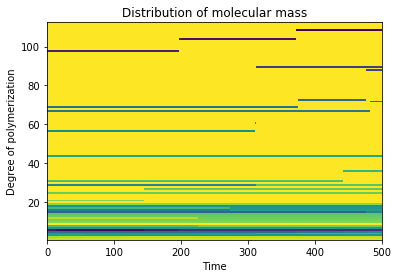

In [23]:
xs = np.array(times) * dt
ys = bin_centers
X, Y = np.meshgrid(xs, ys-1)
Z = (size_distribution).transpose()
pcol = plt.pcolor(X, Y, Z, cmap=plt.cm.viridis_r)
plt.xlabel("Time")
plt.ylabel("Degree of polymerization")
plt.title("Distribution of molecular mass")
#plt.savefig('hex3sites_distr.pdf', bbox_inches='tight')

Run this on a larger computer for longer time